**Exercise 13-1**: In NSFG Cycles 6 and 7, the variable cmdivorcx contains the date of divorce for the respondent’s first marriage, if applicable, encoded in century-months.
Compute the duration of marriages that have ended in divorce, and the duration, so far, of marriages that are ongoing. Estimate the hazard and survival curve for the duration of marriage.
Use resampling to take into account sampling weights, and plot data from several resamples to visualize sampling error.
Consider dividing the respondents into groups by decade of birth, and possibly by age at first marriage.

In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)

In [5]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemResp.dct")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemResp.dat.gz")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/survival.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2006_2010_FemRespSetup.dct")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2006_2010_FemResp.dat.gz")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")

Downloaded nsfg.py


In [7]:
import pandas
import numpy as np

import nsfg
import thinkplot
import thinkstats2
import survival

In [27]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [18]:
def CleanData(resp):
    # Cleans Data
    resp.cmdivorcx.replace([9997, 9998, 9999], np.nan, inplace=True)
    # Creates columns and transforms data
    resp['notdivorced'] = resp.cmdivorcx.isnull().astype(int)
    resp['duration'] = (resp.cmdivorcx - resp.cmmarrhx) / 12.0
    resp['durationsofar'] = (resp.cmintvw - resp.cmmarrhx) / 12.0

    month0 = pandas.to_datetime('1899-12-15')
    dates = [month0 + pandas.DateOffset(months=cm) 
             for cm in resp.cmbirth]
    resp['decade'] = (pandas.DatetimeIndex(dates).year - 1900) // 10

In [19]:
# Hazard Function and Survival Curve
def EstimateSurvival(resp):
    # Creates complete and ongoing variables for Hazard Function
    complete = resp[resp.notdivorced == 0].duration.dropna()
    ongoing = resp[resp.notdivorced == 1].durationsofar.dropna()

    # Call to functions
    hf = survival.EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf

In [10]:
# Resamples by Decade
def ResampleDivorceCurveByDecade(resps):
    # Plots by Decade
    for i in range(41):
        samples = [thinkstats2.ResampleRowsWeighted(resp) 
                   for resp in resps]
        sample = pandas.concat(samples, ignore_index=True)
        groups = sample.groupby('decade')
        if i == 0:
            survival.AddLabelsByDecade(groups, alpha=0.7)

        EstimateSurvivalByDecade(groups, alpha=0.1)

    # Dsiplay plot
    thinkplot.Show(root='survival7',
                   xlabel='years',
                   axis=[0, 28, 0, 1])

In [25]:
def EstimateSurvivalByDecade(groups, **options):
    # Plots Survival by Decade
    thinkplot.PrePlot(len(groups))
    for name, group in groups:
        print(name, len(group))
        _, sf = EstimateSurvival(group)
        thinkplot.Plot(sf, **options)

5 564
6 4230
7 3695
8 1165
9 6
5 537
6 4188
7 3763
8 1168
9 4
5 502
6 4109
7 3848
8 1193
9 8
5 528
6 4211
7 3761
8 1151
9 9
5 516
6 4085
7 3881
8 1167
9 11
5 537
6 4139
7 3767
8 1208
9 9
5 519
6 4189
7 3753
8 1188
9 11
5 472
6 4208
7 3813
8 1157
9 10
5 499
6 4234
7 3738
8 1182
9 7
5 545
6 4199
7 3770
8 1142
9 4
5 532
6 4245
7 3754
8 1123
9 6
5 525
6 4091
7 3824
8 1210
9 10
5 494
6 4210
7 3801
8 1146
9 9
5 501
6 4226
7 3745
8 1181
9 7
5 502
6 4244
7 3712
8 1196
9 6
5 558
6 4163
7 3718
8 1212
9 9
5 510
6 4178
7 3814
8 1150
9 8
5 527
6 4213
7 3729
8 1183
9 8
5 517
6 4083
7 3904
8 1145
9 11
5 488
6 4151
7 3878
8 1137
9 6
5 529
6 4215
7 3758
8 1145
9 13
5 515
6 4170
7 3770
8 1201
9 4
5 519
6 4140
7 3810
8 1186
9 5
5 520
6 4138
7 3891
8 1105
9 6
5 496
6 4138
7 3874
8 1144
9 8
5 494
6 4194
7 3810
8 1151
9 11
5 497
6 4124
7 3830
8 1201
9 8
5 565
6 4193
7 3778
8 1118
9 6
5 516
6 4141
7 3797
8 1199
9 7
5 530
6 4160
7 3728
8 1229
9 13
5 504
6 4167
7 3820
8 1163
9 6
5 508
6 4159
7 3806
8 1177
9 10

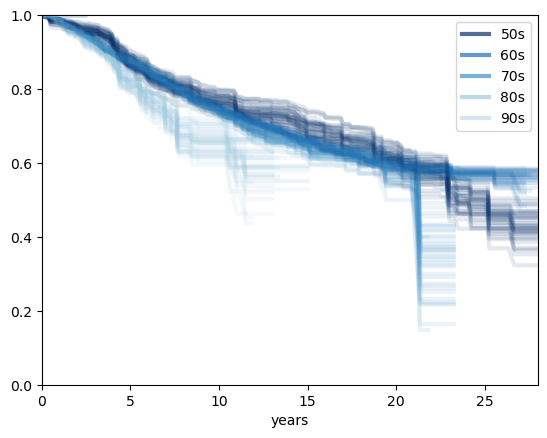

<Figure size 800x600 with 0 Axes>

In [28]:
def main():
    # Uses 2002 data
    resp6 = survival.ReadFemResp2002()
    CleanData(resp6)
    married6 = resp6[resp6.evrmarry==1]
    # Uses 2010 data
    resp7 = survival.ReadFemResp2010()
    CleanData(resp7)
    married7 = resp7[resp7.evrmarry==1]

    ResampleDivorceCurveByDecade([married6, married7])


if __name__ == '__main__':
    main()

